In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import os
import tensorflow as tf
import numpy as np

SEED = 1234
tf.random.set_seed(SEED)

# Get current working directory
cwd = os.getcwd()
cwd

'/content'

# Example: Multi-class Land Use classification
## Uc Merced Land Use Dataset

### Directory structure

    - UCMerced_LandUse/
        - training/
            - agricultural/
                - img1, img2, …, imgN
            - …
            - parkinglot/
                - img1, img2, ... , imgN
        - validation/
            - agricultural/
                - img1, img2, …, imgN
            - …
            - parkinglot/
                - img1, img2, ... , imgN
        - test/
            - agricultural/
                - img1, img2, …, imgN
            - …
            - parkinglot/
                - img1, img2, ... , imgN

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

# Create training ImageDataGenerator object
if apply_data_augmentation:
    train_data_gen = ImageDataGenerator(rotation_range=10,
                                        width_shift_range=10,
                                        height_shift_range=10,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode='constant',
                                        cval=0,
                                        rescale=1./255)
else:
    train_data_gen = ImageDataGenerator(rescale=1./255)

# Create validation and test ImageDataGenerator objects
valid_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Run this cell only if you are using Colab with Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Run this cell only if you are using Colab with Drive
!unzip '/content/drive/My Drive/Keras3/CNN/UC Merced/UCMerced_LandUse.zip'

Archive:  /content/drive/My Drive/Keras3/CNN/UC Merced/UCMerced_LandUse.zip
replace UCMerced_LandUse/test/agricultural/agricultural01.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Create generators to read images from dataset directory
# -------------------------------------------------------
dataset_dir = os.path.join(cwd, 'UCMerced_LandUse')

# Batch size
bs = 8

# img shape
img_h = 256
img_w = 256

num_classes=21

decide_class_indices = False
if decide_class_indices:
    classes = ['agricultural',       # 0
               'airplane',           # 1
               'baseballdiamond',    # 2
               'beach',              # 3
               'buildings',          # 4
               'chaparral',          # 5
               'denseresidensial',   # 6
               'forest',             # 7
               'freeway',            # 8
               'golfcourse',         # 9
               'harbor',             # 10
               'intersection',       # 11
               'mediumresidential',  # 12
               'mobilehomepark',     # 13
               'overpass',           # 14
               'parkinglot',         # 15
               'river',              # 16
               'runway',             # 17
               'sparseresidential',  # 18
               'storagetanks',       # 19
               'tenniscourt']        # 20
else:
    classes=None

# Training
training_dir = os.path.join(dataset_dir, 'training')
train_gen = train_data_gen.flow_from_directory(training_dir,
                                               batch_size=bs,
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=SEED)  # targets are directly converted into one-hot vectors

# Validation
validation_dir = os.path.join(dataset_dir, 'validation')
valid_gen = valid_data_gen.flow_from_directory(validation_dir,
                                               batch_size=bs,
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=SEED)

# Test
test_dir = os.path.join(dataset_dir, 'test')
test_gen = test_data_gen.flow_from_directory(test_dir,
                                             batch_size=bs,
                                             classes=classes,
                                             class_mode='categorical',
                                             shuffle=False,
                                             seed=SEED)

Found 1470 images belonging to 21 classes.
Found 315 images belonging to 21 classes.
Found 315 images belonging to 21 classes.


In [ ]:
# Check how keras assigned the labels
train_gen.class_indices

{'agricultural': 0,
 'airplane': 1,
 'baseballdiamond': 2,
 'beach': 3,
 'buildings': 4,
 'chaparral': 5,
 'denseresidential': 6,
 'forest': 7,
 'freeway': 8,
 'golfcourse': 9,
 'harbor': 10,
 'intersection': 11,
 'mediumresidential': 12,
 'mobilehomepark': 13,
 'overpass': 14,
 'parkinglot': 15,
 'river': 16,
 'runway': 17,
 'sparseresidential': 18,
 'storagetanks': 19,
 'tenniscourt': 20}

In [ ]:
# Create Dataset objects
# ----------------------

# Training
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes]))

# Shuffle (Already done in generator..)
# train_dataset = train_dataset.shuffle(buffer_size=len(train_gen))

# Normalize images (Already done in generator..)
# def normalize_img(x_, y_):
#     return tf.cast(x_, tf.float32) / 255., y_

# train_dataset = train_dataset.map(normalize_img)

# 1-hot encoding <- for categorical cross entropy (Already done in generator..)
# def to_categorical(x_, y_):
#     return x_, tf.one_hot(y_, depth=10)

# train_dataset = train_dataset.map(to_categorical)

# Divide in batches (Already done in generator..)
# train_dataset = train_dataset.batch(bs)

# Repeat
# Without calling the repeat function the dataset
# will be empty after consuming all the images
train_dataset = train_dataset.repeat()

# Validation
# ----------
valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes]))

# Repeat
valid_dataset = valid_dataset.repeat()

# Test
# ----
test_dataset = tf.data.Dataset.from_generator(lambda: test_gen,
                                              output_types=(tf.float32, tf.float32),
                                              output_shapes=([None, img_h, img_w, 3], [None, num_classes]))

# Repeat
test_dataset = valid_dataset.repeat()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Visualize training images

iterator = iter(train_dataset)

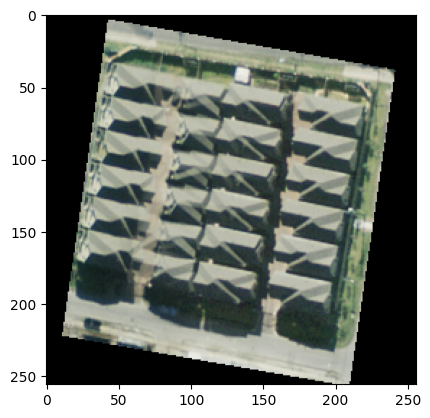

In [ ]:
augmented_img, target = next(iterator)

augmented_img = np.array(augmented_img[0])   # First element
augmented_img = augmented_img * 255           # denormalize

plt.imshow(np.uint8(augmented_img))


**Classic CNN Feature extraction -> Classifier**

In [ ]:
# Architecture: Features extraction -> Classifier

start_f = 8
depth = 5

model = tf.keras.Sequential()

# Features extraction
for i in range(depth):

    if i == 0:
        input_shape = [img_h, img_w, 3]
    else:
        input_shape=[None]

    # Conv block: Conv2D -> Activation -> Pooling
    model.add(tf.keras.layers.Conv2D(filters=start_f,
                                     kernel_size=(3, 3),
                                     strides=(1, 1),
                                     padding='same',
                                     input_shape=input_shape))
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

    start_f *= 2

# Classifier
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=512, activation='relu'))
model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Visualize created model as a table
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 256, 256, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 256, 256, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 128, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 21)             │        10,773 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,303,973 (16.42 MB)

 Trainable params: 4,303,973 (16.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Visualize initialized weights
model.weights

In [ ]:
# Optimization params
# -------------------

# Loss
loss = tf.keras.losses.CategoricalCrossentropy()

# learning rate
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Validation metrics
# ------------------

metrics = ['accuracy']
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
import os
from datetime import datetime


cwd = os.getcwd()

exps_dir = os.path.join('/content/drive/My Drive/Keras3/CNN', 'UC Merced')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)

callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.weights.h5'),
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)

# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    callbacks.append(es_callback)

In [ ]:
model.fit(x=train_dataset,
          epochs=100,  #### set repeat in training dataset
          steps_per_epoch=len(train_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_gen),
          callbacks=callbacks)

# How to visualize Tensorboard

# 1. tensorboard --logdir EXPERIMENTS_DIR --port PORT     <- from terminal
# 2. localhost:PORT   <- in your browser

Epoch 1/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 33s 153ms/step - accuracy: 0.0441 - loss: 3.0354 - val_accuracy: 0.1810 - val_loss: 2.7907
Epoch 2/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 24s 129ms/step - accuracy: 0.1411 - loss: 2.7268 - val_accuracy: 0.1714 - val_loss: 2.4796
Epoch 3/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 24s 133ms/step - accuracy: 0.1865 - loss: 2.5016 - val_accuracy: 0.3492 - val_loss: 2.2115
Epoch 4/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 40s 221ms/step - accuracy: 0.2925 - loss: 2.2074 - val_accuracy: 0.2540 - val_loss: 2.1910
Epoch 5/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 24s 129ms/step - accuracy: 0.3819 - loss: 2.0529 - val_accuracy: 0.4571 - val_loss: 1.8040
Epoch 6/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 40s 220ms/step - accuracy: 0.4177 - loss: 1.8298 - val_accuracy: 0.4222 - val_loss: 1.7609
Epoch 7/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 22s 119ms/step - accuracy: 0.4435 - loss: 1.6274 - val_accuracy: 0.4921 - val_loss: 1.5118
Epoch 8/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 24s 130ms/step - accuracy: 0.4951 -

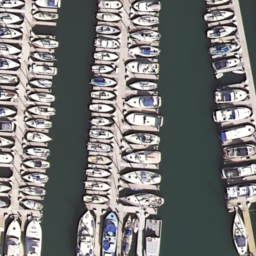

In [ ]:
# Let's visualize the activations of our network
from PIL import Image

test_iter = iter(test_dataset)

# Get a test image
test_img = next(test_iter)[0]
test_img = test_img[0]

# Visualize the image
Image.fromarray(np.uint8(np.array(test_img)*255.))

In [ ]:
# Get the activations (the output of each ReLU layer)
layer_outputs = [layer.output for layer in model.layers if isinstance(layer, tf.keras.layers.ReLU)]
# We can do it by creating a new model (activation_model) with model.input as input
# and all the ReLU activations as output
activation_model = tf.keras.Model(inputs=model.input, outputs=layer_outputs)
# Finally we get the output values given the imput test image
activations = activation_model.predict(tf.expand_dims(test_img, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
def display_activation(activations, act_index):
    # activations: list of all the activations
    # act_index: the layer we want to visualize (an int in [0, network depth) )
    activation = activations[act_index]
    activation = tf.image.resize(activation, size=[128, 128])
    col_size = activations[0].shape[-1]
    row_size = 1 + act_index
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(8*2.5, 8*1.5), squeeze=False)
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1

In [ ]:
# Print Confusion Matrix and Classification Report (Precision, Recall, and F1-score)
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

Y_prediction = model.predict_generator(test_gen, len(test_gen))
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_prediction,axis = 1)
# Convert validation observations to one hot vectors
Y_true = test_gen.classes
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
class_report = classification_report(Y_true, Y_pred_classes,
                                     target_names=test_gen.class_indices.keys())  # target_names must be ordered depending on the class labels
print('Confusion Matrix:')
print(confusion_mtx)
print()
print('Classification Report:')
print(class_report)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
Confusion Matrix:
[[14  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  9  0  0  1  0  0  0  0  0  1  0  0  0  0  0  0  0  0  4  0]
 [ 0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 14  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  4  0  2  0  0  0  0  0  0  1  2  0  0  0  0  6  0]
 [ 0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 12  0  0  0  0  1  1  1  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  9  0  0  0  3  0  2  0  0  0  0  0  0]
 [ 1  0  1  0  0  0  0  0  0  8  0  0  0  0  0  0  0  1  4  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 13  0  0  1  0  0  0  1  0  0  0]
 [ 0  0  0  0  1  0  1  0  0  0  0 13  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0  0  0  7  5  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0 14  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  

# Transfer Learning:
## e.g., VGG16

In [ ]:
# Load VGG16 Model

vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Create Model
# ------------

finetuning = True

if finetuning:
    freeze_until = 15 # layer from which we want to fine-tune

    for layer in vgg.layers[:freeze_until]:
        layer.trainable = False
else:
    vgg.trainable = False

model = tf.keras.Sequential()
model.add(vgg)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

# Visualize created model as a table
model.summary()

# Visualize initialized weights
model.weights

In [ ]:
# Optimization params
# -------------------

# Loss
loss = tf.keras.losses.CategoricalCrossentropy()

# learning rate
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Validation metrics
# ------------------

metrics = ['accuracy']
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
import os
from datetime import datetime


cwd = os.getcwd()

exps_dir = os.path.join('/content/drive/My Drive/Keras3/CNN', 'UC Merced')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)

callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.weights.h5'),
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)

# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    callbacks.append(es_callback)

In [ ]:
model.fit(x=train_dataset,
          epochs=100,  #### set repeat in training dataset
          steps_per_epoch=len(train_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_gen),
          callbacks=callbacks)

Epoch 1/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 69s 319ms/step - accuracy: 0.3158 - loss: 2.3936 - val_accuracy: 0.7048 - val_loss: 0.9014
Epoch 2/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 37s 204ms/step - accuracy: 0.7178 - loss: 0.8868 - val_accuracy: 0.8063 - val_loss: 0.6419
Epoch 3/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 36s 198ms/step - accuracy: 0.8044 - loss: 0.6581 - val_accuracy: 0.8603 - val_loss: 0.4990
Epoch 4/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 38s 204ms/step - accuracy: 0.8177 - loss: 0.5087 - val_accuracy: 0.8698 - val_loss: 0.3810
Epoch 5/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 38s 208ms/step - accuracy: 0.8811 - loss: 0.3347 - val_accuracy: 0.9238 - val_loss: 0.1991
Epoch 6/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 35s 189ms/step - accuracy: 0.9072 - loss: 0.3051 - val_accuracy: 0.9143 - val_loss: 0.2163
Epoch 7/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 36s 194ms/step - accuracy: 0.9108 - loss: 0.2679 - val_accuracy: 0.9048 - val_loss: 0.3222
Epoch 8/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 35s 188ms/step - accuracy: 0.9281 -

In [ ]:
# model.load_weights('/path/to/checkpoint')  # use this if you want to restore saved model

eval_out = model.evaluate(x=test_dataset,
                          steps=len(test_gen),
                          verbose=0)
eval_out

[0.34011757373809814, 0.882539689540863]

## Visualize Confusion Matrix


Generate and plot the confusion matrix as a heatmap using seaborn for better readability, showing the performance across all classes.


<Figure size 1500x1200 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Confusion Matrix')

Text(0.5, 102.72222222222219, 'Predicted Labels')

Text(158.22222222222223, 0.5, 'True Labels')

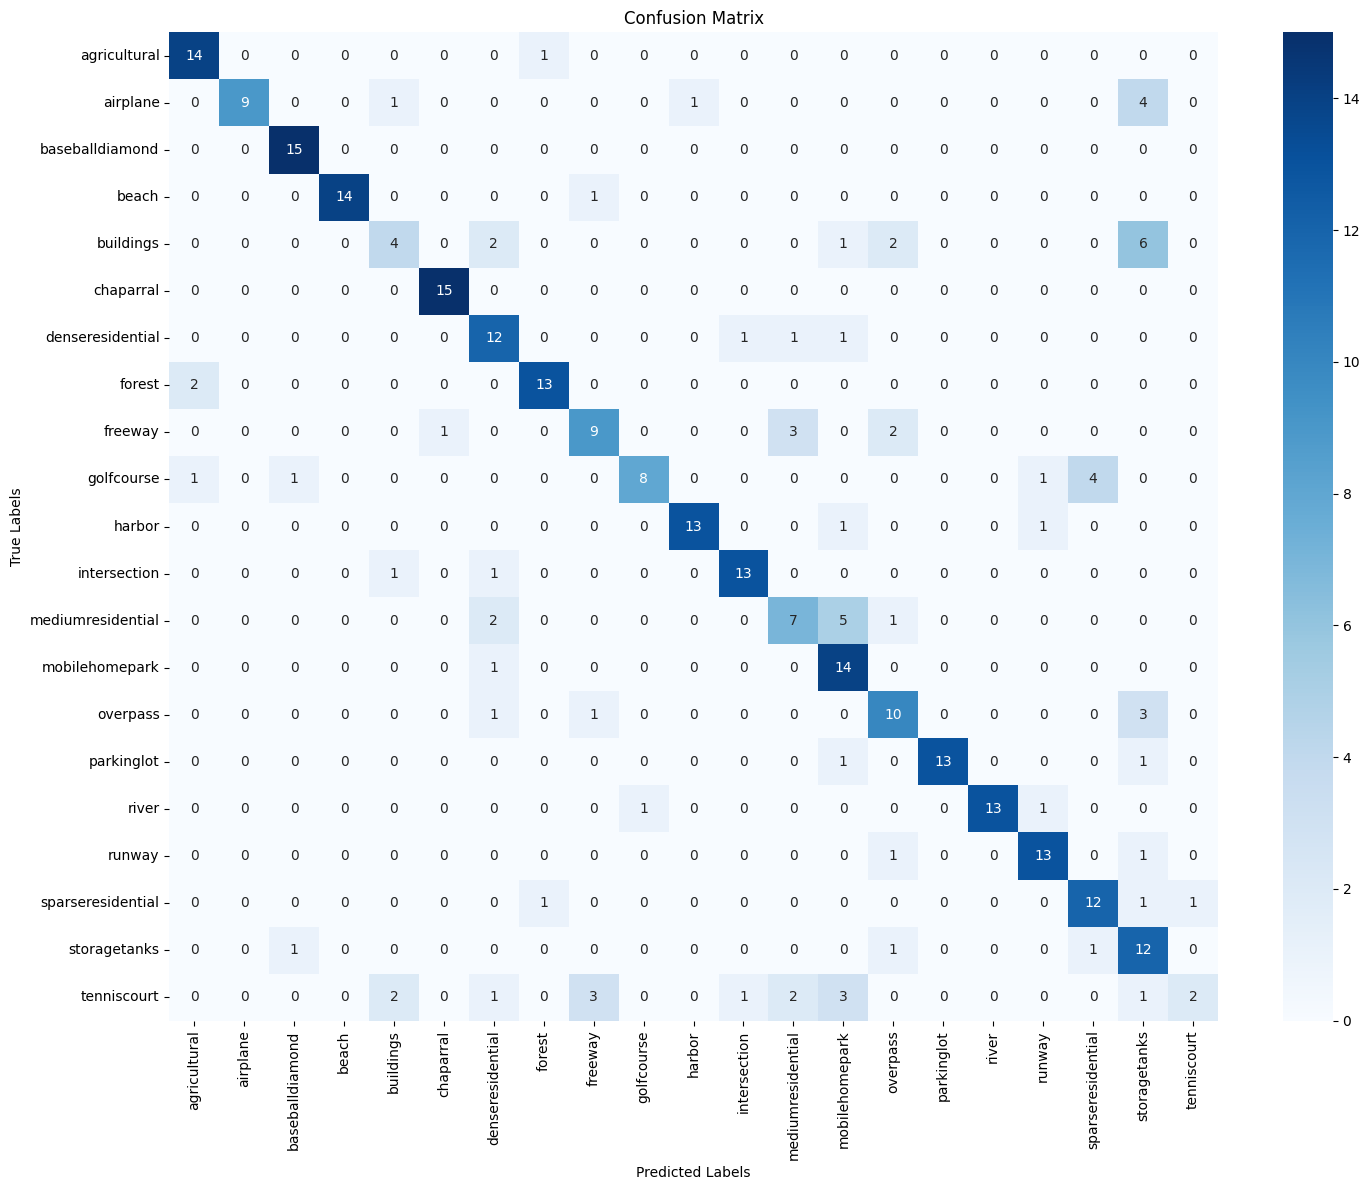

In [ ]:
plt.figure(figsize=(15, 12))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_gen.class_indices.keys(),
            yticklabels=test_gen.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

## Generate ROC Curves and AUC


Calculate and plot the Receiver Operating Characteristic (ROC) curve and Area Under the Curve (AUC) score for each class using a one-vs-rest strategy.


<Figure size 1000x800 with 0 Axes>

Text(0.5, 1.0, 'Receiver Operating Characteristic (ROC) Curve - One-vs-Rest')

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

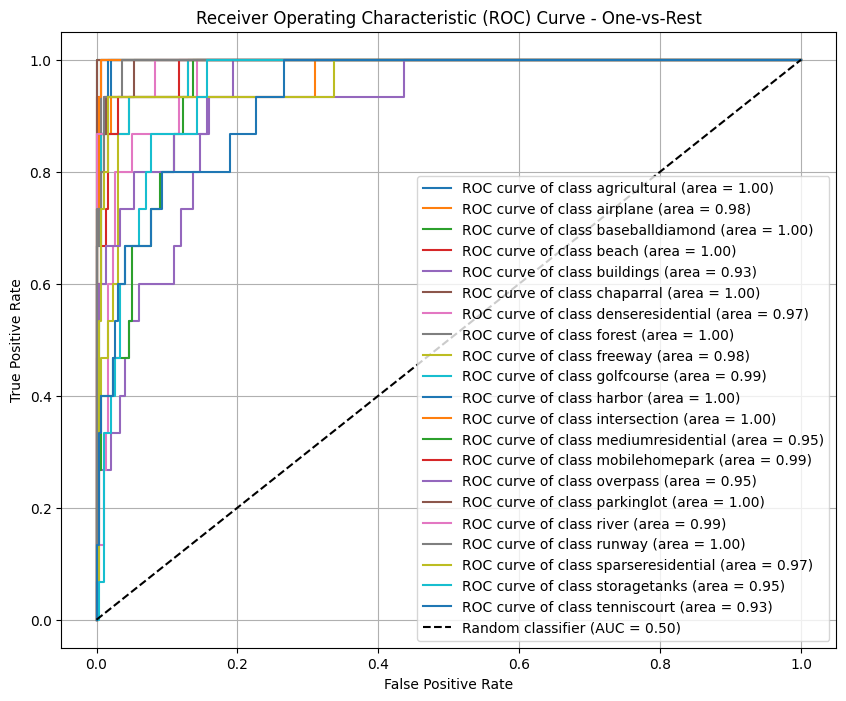

In [ ]:
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical

# Convert Y_true to a one-hot encoded format
Y_true_one_hot = to_categorical(Y_true, num_classes=num_classes)

# Initialize a Matplotlib figure and axes for plotting the ROC curves
plt.figure(figsize=(10, 8))

# Get class names from the generator
class_labels = list(test_gen.class_indices.keys())

# For each class (from 0 to num_classes - 1):
for i in range(num_classes):
    # Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds
    fpr, tpr, thresholds = roc_curve(Y_true_one_hot[:, i], Y_prediction[:, i])

    # Calculate the Area Under the Curve (AUC)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve for the current class
    plt.plot(fpr, tpr, label=f'ROC curve of class {class_labels[i]} (area = {roc_auc:.2f})')

# Plot a diagonal dashed line (representing a random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier (AUC = 0.50)')

# Add a title to the plot
plt.title('Receiver Operating Characteristic (ROC) Curve - One-vs-Rest')
# Label the x-axis
plt.xlabel('False Positive Rate')
# Label the y-axis
plt.ylabel('True Positive Rate')
# Add a legend to the plot
plt.legend(loc='lower right')
# Display the plot
plt.grid(True)
plt.show()


## Summary of Model Performance

Based on the Confusion Matrix and ROC Curves:

### Confusion Matrix Analysis:
- **Overall Accuracy**: The model achieved an overall accuracy of approximately 75% on the test set, as indicated by the classification report. This means that 75% of the predictions were correct.
- **Class-wise Performance**: Some classes, like 'baseballdiamond', 'beach', and 'chaparral', show very high recall and precision, indicating the model performs exceptionally well for these categories. For example, 'baseballdiamond' and 'chaparral' have 100% recall.
- **Misclassifications**: There are noticeable misclassifications in certain classes. For instance, 'buildings' has a low recall (0.27) and 'tenniscourt' has a very low recall (0.13), suggesting the model struggles to correctly identify these images. 'storagetanks' also shows significant misclassifications with a recall of 0.80 but a precision of 0.41, implying that while it identifies many storage tanks, it also incorrectly labels other classes as storage tanks.
- **Common Confusions**: The heatmap visually highlights areas of confusion. For example, some 'buildings' are misclassified as 'storagetanks' or other residential areas. 'tenniscourt' images are often confused with 'buildings', 'dense residential', or 'mobilehomepark'.

### ROC Curve and AUC Analysis:
- **Overall Discriminative Power**: The ROC curves and their corresponding AUC values provide a good measure of the model's ability to distinguish between classes. A higher AUC (closer to 1.0) indicates better discriminative power.
- **High-Performing Classes**: Classes such as 'baseballdiamond' (AUC close to 1.0), 'beach', 'chaparral', and 'harbor' generally exhibit high AUC scores, confirming their strong performance as seen in the confusion matrix.
- **Low-Performing Classes**: Classes that were difficult to distinguish in the confusion matrix, like 'tenniscourt' and 'buildings', generally show lower AUC scores, indicating poorer performance in separating these classes from others.
- **Visual Insights**: The ROC plot clearly shows which classes have curves closer to the top-left corner (better performance) and which are closer to the diagonal line (poorer performance, close to random guessing).

## Summary of Model Performance

Based on the Confusion Matrix and ROC Curves:

### Confusion Matrix Analysis:
- **Overall Accuracy**: The model achieved an overall accuracy of approximately 75% on the test set, as indicated by the classification report. This means that 75% of the predictions were correct.
- **Class-wise Performance**: Some classes, like 'baseballdiamond', 'beach', and 'chaparral', show very high recall and precision, indicating the model performs exceptionally well for these categories. For example, 'baseballdiamond' and 'chaparral' have 100% recall.
- **Misclassifications**: There are noticeable misclassifications in certain classes. For instance, 'buildings' has a low recall (0.27) and 'tenniscourt' has a very low recall (0.13), suggesting the model struggles to correctly identify these images. 'storagetanks' also shows significant misclassifications with a recall of 0.80 but a precision of 0.41, implying that while it identifies many storage tanks, it also incorrectly labels other classes as storage tanks.
- **Common Confusions**: The heatmap visually highlights areas of confusion. For example, some 'buildings' are misclassified as 'storagetanks' or other residential areas. 'tenniscourt' images are often confused with 'buildings', 'dense residential', or 'mobilehomepark'.

### ROC Curve and AUC Analysis:
- **Overall Discriminative Power**: The ROC curves and their corresponding AUC values provide a good measure of the model's ability to distinguish between classes. A higher AUC (closer to 1.0) indicates better discriminative power.
- **High-Performing Classes**: Classes such as 'baseballdiamond' (AUC close to 1.0), 'beach', 'chaparral', and 'harbor' generally exhibit high AUC scores, confirming their strong performance as seen in the confusion matrix.
- **Low-Performing Classes**: Classes that were difficult to distinguish in the confusion matrix, like 'tenniscourt' and 'buildings', generally show lower AUC scores, indicating poorer performance in separating these classes from others.
- **Visual Insights**: The ROC plot clearly shows which classes have curves closer to the top-left corner (better performance) and which are closer to the diagonal line (poorer performance, close to random guessing).